/var/folders/mj/vl8lzxz54kq5ykc7s_pzj2980000gn/T/ipykernel_5387/2973855904.py:87: RuntimeWarning: overflow encountered in exp
  dcf = A * (np.exp(-β * u) / A - 1)
/var/folders/mj/vl8lzxz54kq5ykc7s_pzj2980000gn/T/ipykernel_5387/2973855904.py:90: RuntimeWarning: invalid value encountered in multiply
  C = dx * np.sum(dcf * (ni_grid - nj_grid), axis = 1)
/opt/anaconda3/envs/AML/lib/python3.10/site-packages/matplotlib/ticker.py:2133: RuntimeWarning: overflow encountered in multiply
  ticks = np.arange(low, high + 1) * step + best_vmin


OverflowError: cannot convert float infinity to integer

<Figure size 640x480 with 1 Axes>

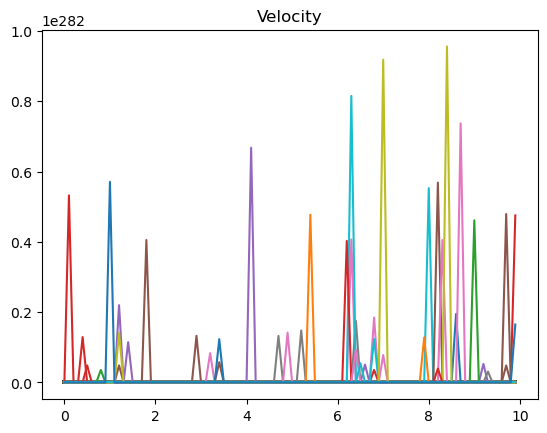

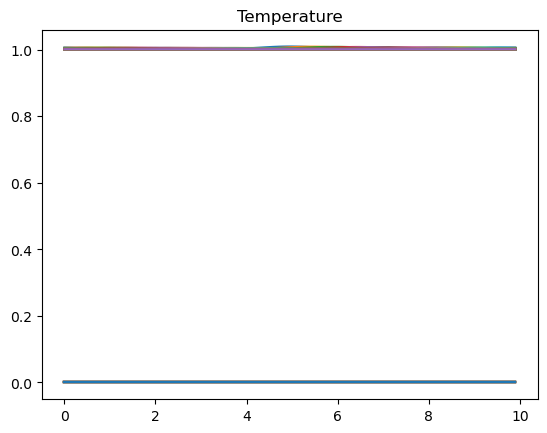

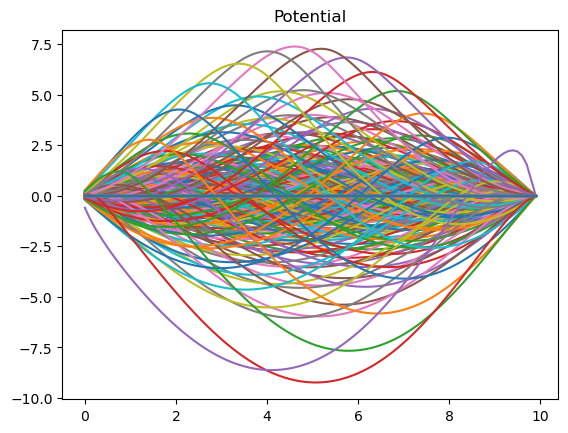

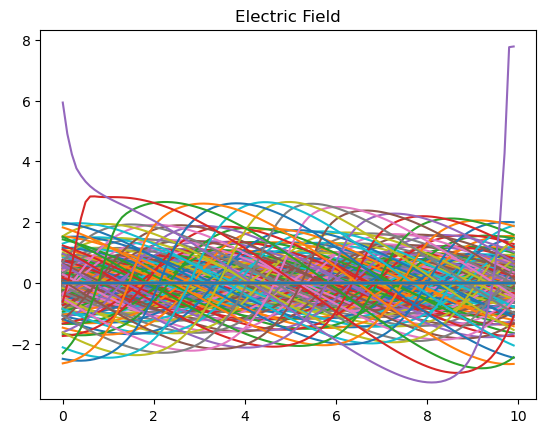

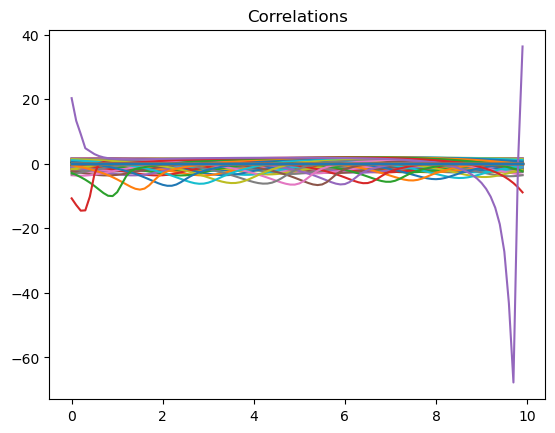

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

# Shift to Left
def l(array):
    return np.roll(array, 1, axis=-1)

# Shift to Right
def r(array):
    return np.roll(array, -1, axis=-1)

# Derivative
def ddx(array, dx):
    return (array - l(array)) / dx

# Second Derivative
def d2dx2(array, dx):
    return (r(array) - 2 * array + l(array)) / (dx * dx)

# Save Snap
def snapshot(fields, fieldConservations, n, u, T, Φ, C, cur_snap, dx, X):
    fields["Density"][cur_snap] = n
    fields["Velocity"][cur_snap] = u
    fields["Temperature"][cur_snap] = T
    fields["Potential"][cur_snap] = Φ
    fields["Electric Field"][cur_snap] = -ddx(Φ, dx)
    fields["Correlations"][cur_snap] = C

    fieldConservations["Density Integral"][cur_snap] = np.trapz(n, X)
    fieldConservations["Velocity Integral"][cur_snap] = np.trapz(u, X)
    fieldConservations["Temperature Integral"][cur_snap] = np.trapz(T, X)
    fieldConservations["Potential Sum"][cur_snap] = np.sum(Φ)
    fieldConservations["Electric Field Sum"][cur_snap] = np.sum(-ddx(Φ, dx))
    fieldConservations["Electric Field Integral"][cur_snap] = np.trapz(-ddx(Φ, dx), X)
    fieldConservations["Correlations Sum"][cur_snap] = np.sum(C)
    fieldConservations["Correlations Integral"][cur_snap] = np.trapz(C, X)

def solve_poisson(nx, n, dx):
    """
    Solves the Poisson equation with periodic boundary conditions using a special Thomas algorithm.
    """
    mean_n = np.mean(n)
    ρ = -4 * np.pi * (n - mean_n) * dx**2

    # Step 1: Compute potential at mesh point 0
    Φ = np.zeros(nx)
    Φ[0] = np.sum((np.arange(1, nx + 1) * ρ)) / nx

    # Step 2: Compute potential at mesh point 1
    Φ[1] = ρ[0] + 2 * Φ[0]

    # Step 3: Compute remaining potentials
    for i in range(2, nx):
        Φ[i] = ρ[i - 1] + 2 * Φ[i - 1] - Φ[i - 2]

    return Φ

# def solve_correlations(C):
#     return C  # TODO: Placeholder

def solve_correlations(n, L, dx, X, κ, Γ, T):
    # Constants and mesh setup
    nx = len(X)
    C = np.zeros_like(n)
    β = 1 / T

    # Extend dimensions for interactions at different locations
    Xi_grid, Xj_grid = np.meshgrid(X, X, indexing='ij')
    ni_grid, nj_grid = np.meshgrid(n, n, indexing='ij')

    # Compute distances between points
    distance = np.abs(Xi_grid - Xj_grid)
    distance = np.minimum(distance, L - distance)

    # distance[distance < ion sphere radius] = ion sphere radius  # Fix minimum distance to ions sphere radius
    distance[distance == 0] = 1e-10  # Prevent division by zero

    # Compute Coulomb Potential: u(r)
    u = 1 / distance

    # Compute Parametrization Factor: A(κ, Γ)
    A = 1 + 1.5 * Γ * np.exp(-κ)
    
    # Compute Direct Correlation Function: c(r)
    dcf = A * (np.exp(-β * u) / A - 1)

    # Calculate Correlation Interactions by integrating j axis
    C = dx * np.sum(dcf * (ni_grid - nj_grid), axis = 1)

    return C

# Spatial Domain
nx = int(1e2)
L = 10
dx = L / nx
X = np.linspace(0, L, nx, endpoint=False)

# Temporal Domain
end_time = 10
t = 0
num_snaps = 50
snap_interval = end_time / num_snaps
cur_snap = 0

# Parameters
mean_n = 3 / (4*np.pi)
Γ = 10
κ = 2
therm_cond = 0.1
cfl_safety = 0.1

# Memory Allocation for Fields
fields = {
    "Density": np.empty((num_snaps+1, nx)),
    "Velocity": np.empty((num_snaps+1, nx)),
    "Temperature": np.empty((num_snaps+1, nx)),
    "Potential": np.empty((num_snaps+1, nx)),
    "Electric Field": np.empty((num_snaps+1, nx)),
    "Correlations": np.empty((num_snaps+1, nx))
}

# Conservation checks
fieldConservations = {
    "Density Integral": np.empty(num_snaps+1),
    "Velocity Integral": np.empty(num_snaps+1),
    "Temperature Integral": np.empty(num_snaps+1), 
    "Potential Sum": np.empty(num_snaps+1),
    "Electric Field Sum": np.empty(num_snaps+1), 
    "Electric Field Integral": np.empty(num_snaps+1),
    "Correlations Sum": np.empty(num_snaps+1),
    "Correlations Integral": np.empty(num_snaps+1)
}


# Initial Conditions
n = mean_n + 0.01 * np.exp(-(X - np.mean(X))**2)
u = 5 * np.ones_like(X) + 0.01 * np.exp(-(X - np.mean(X))**2)
T = np.ones_like(X) + 0.01 * np.exp(-(X - np.mean(X))**2)
Φ = solve_poisson(nx, n, dx)
C = solve_correlations(n, L, dx, X, κ, Γ, T)  # TODO: Add Correlations

# Save Initial Snapshot
snapshot(fields, fieldConservations, n, u, T, Φ, C, cur_snap, dx, X)
cur_snap += 1

# Time Integration
while t < end_time:
    # Calculate dt and next snapshot time
    max_field_speed = np.max(np.array([np.abs(u).max()]))
    dt = cfl_safety * dx / max_field_speed

    next_snap_time = cur_snap * snap_interval
    if t + dt >= next_snap_time:
        dt = next_snap_time - t  # Adjust dt to exactly reach the snapshot time

    # Update fields
    Φ = solve_poisson(nx, n, dx)  # Solve Poisson Equation
    C = solve_correlations(n, L, dx, X, κ, Γ, T)  # Solve Correlations Equation
    n -= dt * ddx(n * u, dx)
    u -= dt * ( u * ddx(u, dx) - T * ddx(n, dx) / n + Γ * T * ddx(Φ, dx) - ddx(C, dx) )  # Subtract Correlations Term: -ddx(C) in the parenthesis
    T -= dt * ( u * ddx(T, dx) - d2dx2(therm_cond * T, dx) )

    # Time update
    t += dt

    if t >= next_snap_time:
        snapshot(fields, fieldConservations, n, u, T, Φ, C, cur_snap, dx, X)
        cur_snap += 1

# Plotting
for fieldName, fieldValues in fields.items():
    plt.figure()
    for snap in fieldValues:
        plt.plot(X, snap)
    plt.title(fieldName)
    plt.show()

# Below is correct

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

# Shift to Left
def l(array):
    return np.roll(array, 1, axis=-1)

# Shift to Right
def r(array):
    return np.roll(array, -1, axis=-1)

# Derivative
def ddx(array, dx):
    return (array - l(array)) / dx

# Second Derivative
def d2dx2(array, dx):
    return (r(array) - 2 * array + l(array)) / (dx * dx)

# Check Validity
def force_valid(n, u, T):
    n = np.clip(n, 0, 1)
    u = np.clip(u, 0, np.inf)
    T = np.clip(T, 0, np.inf)
    return n, u, T

# Save Snap
def snapshot(fields, fieldConservations, n, u, T, Φ, C, cur_snap, dx, X):
    fields["Density"][cur_snap] = n
    fields["Velocity"][cur_snap] = u
    fields["Temperature"][cur_snap] = T
    fields["Potential"][cur_snap] = Φ
    fields["Electric Field"][cur_snap] = -ddx(Φ, dx)
    fields["Correlations"][cur_snap] = C

    fieldConservations["Density Integral"][cur_snap] = np.trapz(n, X)
    fieldConservations["Velocity Integral"][cur_snap] = np.trapz(u, X)
    fieldConservations["Temperature Integral"][cur_snap] = np.trapz(T, X)
    fieldConservations["Potential Sum"][cur_snap] = np.sum(Φ)
    fieldConservations["Electric Field Sum"][cur_snap] = np.sum(-ddx(Φ, dx))
    fieldConservations["Electric Field Integral"][cur_snap] = np.trapz(-ddx(Φ, dx), X)
    fieldConservations["Correlations Sum"][cur_snap] = np.sum(C)
    fieldConservations["Correlations Integral"][cur_snap] = np.trapz(C, X)

def solve_poisson(nx, n, dx):
    """
    Solves the Poisson equation with periodic boundary conditions using a special Thomas algorithm.
    """
    mean_n = np.mean(n)
    ρ = -4 * np.pi * (n - mean_n) * dx**2

    # Step 1: Compute potential at mesh point 0
    Φ = np.zeros(nx)
    Φ[0] = np.sum((np.arange(1, nx + 1) * ρ)) / nx

    # Step 2: Compute potential at mesh point 1
    Φ[1] = ρ[0] + 2 * Φ[0]

    # Step 3: Compute remaining potentials
    for i in range(2, nx):
        Φ[i] = ρ[i - 1] + 2 * Φ[i - 1] - Φ[i - 2]

    return Φ

def solve_correlations(C):
    return C  # TODO: Placeholder

# Spatial Domain
nx = int(1e2)
L = 10
dx = L / nx
X = np.linspace(0, L, nx, endpoint=False)

# Temporal Domain
end_time = 200
t = 0
num_snaps = 1000
snap_interval = end_time / num_snaps
cur_snap = 0

# Parameters
mean_n = 3 / (4*np.pi)
Γ = 10
κ = 2
therm_cond = 0.1
cfl_safety = 0.1

# Memory Allocation for Fields
fields = {
    "Density": np.empty((num_snaps+1, nx)),
    "Velocity": np.empty((num_snaps+1, nx)),
    "Temperature": np.empty((num_snaps+1, nx)),
    "Potential": np.empty((num_snaps+1, nx)),
    "Electric Field": np.empty((num_snaps+1, nx)),
    "Correlations": np.empty((num_snaps+1, nx))
}

# Conservation checks
fieldConservations = {
    "Density Integral": np.empty(num_snaps+1),
    "Velocity Integral": np.empty(num_snaps+1),
    "Temperature Integral": np.empty(num_snaps+1), 
    "Potential Sum": np.empty(num_snaps+1),
    "Electric Field Sum": np.empty(num_snaps+1), 
    "Electric Field Integral": np.empty(num_snaps+1),
    "Correlations Sum": np.empty(num_snaps+1),
    "Correlations Integral": np.empty(num_snaps+1)
}


# Initial Conditions
n = mean_n + 0.01 * np.exp(-(X - np.mean(X))**2)
u = 5 * np.ones_like(X) + 0.01 * np.exp(-(X - np.mean(X))**2)
T = np.ones_like(X) + 0.01 * np.exp(-(X - np.mean(X))**2)
Φ = solve_poisson(nx, n, dx)
C = np.zeros_like(X)  # TODO: Add Correlations

# Save Initial Snapshot
snapshot(fields, fieldConservations, n, u, T, Φ, C, cur_snap, dx, X)
cur_snap += 1

# Time Integration
while t < end_time:
    # Calculate dt and next snapshot time
    max_field_speed = np.max(np.array([np.abs(u).max()]))
    dt = cfl_safety * dx / max_field_speed

    next_snap_time = cur_snap * snap_interval
    if t + dt >= next_snap_time:
        dt = next_snap_time - t  # Adjust dt to exactly reach the snapshot time

    # Update fields
    Φ = solve_poisson(nx, n, dx)  # Solve Poisson Equation
    C = solve_correlations(C)  # Solve Correlations Equation
    n -= dt * ddx(n * u, dx)
    u -= dt * ( u * ddx(u, dx) - T * ddx(n, dx) / n + Γ * T * ddx(Φ, dx))  # Subtract Correlations Term: -ddx(C) in the parenthesis
    T -= dt * ( u * ddx(T, dx) - d2dx2(therm_cond * T, dx) )

    # Check Validity
    n, u, T = force_valid(n, u, T)

    # Time update
    t += dt

    # Snapshot
    if t >= next_snap_time:
        snapshot(fields, fieldConservations, n, u, T, Φ, C, cur_snap, dx, X)
        cur_snap += 1

# Plotting
for fieldName, fieldValues in fields.items():
    plt.figure()
    for snap in fieldValues:
        plt.plot(X, snap)
    plt.title(fieldName)
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [79]:
# Plot Conserved Values
for fieldName, fieldValues in fieldConservations.items():
    plt.figure()
    plt.plot(np.arange(num_snaps + 1), fieldValues)
    plt.title(fieldName)
    plt.xlabel("Time")
    plt.ylabel(fieldName)
    plt.show()

# Heat Map
for fieldName, fieldValues in fields.items():
    plt.figure()
    plt.imshow(fieldValues, cmap='hot', interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.title(fieldName)
    plt.ylabel("Time (Snapshots)")
    plt.xlabel("Space (X)")
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [84]:
%matplotlib notebook
# %matplotlib widget
import matplotlib.pyplot as plt
# import matplotlib.animation as animation
from IPython.display import display, HTML
from matplotlib.animation import FuncAnimation

# Animation
def fieldAnimations(fieldName, fieldValues):
    fig, ax = plt.subplots()
    line, = ax.plot(X, fieldValues[0])

    def update(frame):
        validData = fieldValues[frame][np.isfinite(fieldValues[frame])]
        line.set_ydata(fieldValues[frame])
        ax.set_title(f'{fieldName} at Time = {frame * snap_interval:.2f}s')
        lowerBound = 0.999 * np.min(validData)
        upperBound = 1.001 * np.max(validData)
        ax.set_ylim(lowerBound, upperBound)
        return line,

    ani = FuncAnimation(fig, update, frames=num_snaps+1, interval=50, blit=True)
    return ani

for fieldName, fieldValues in fields.items():
    ani = fieldAnimations(fieldName, fieldValues)
    display(HTML(ani.to_jshtml()))
    # plt.close()
    # plt.show()


<IPython.core.display.Javascript object>

# HNC

Converged in 3121 iterations.


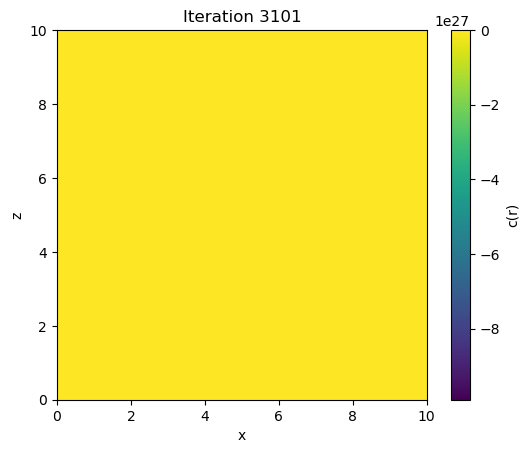

In [3]:
import numpy as np
from scipy.fftpack import fftn, ifftn
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from PIL import Image

# Define parameters
L = 10.0  # Box length
original_nx = 100
new_nx = 16  # New number of grid points
ny, nz = new_nx, new_nx  # Number of grid points in y and z directions
dy, dz = L / ny, L / nz  # Grid spacing in y and z directions

# Original x grid and new x grid
x_original = np.linspace(0, L, original_nx, endpoint=False)
x_new = np.linspace(0, L, new_nx, endpoint=False)

# Assume n(x) and T(x) are defined elsewhere as 1D arrays with 100 points
# Example:
# n = np.random.rand(original_nx)
# T = np.random.rand(original_nx) * 300 + 10

# Interpolate n(x) and T(x) to new grid
n_interpolator = interp1d(x_original, n, kind='cubic')
T_interpolator = interp1d(x_original, T, kind='cubic')
n_new = n_interpolator(x_new)
T_new = T_interpolator(x_new)

# Create the new 3D grid
x = np.linspace(0, L, new_nx, endpoint=False)
y = np.linspace(0, L, ny, endpoint=False)
z = np.linspace(0, L, nz, endpoint=False)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Extend n_new and T_new to 3D
n = np.tile(n_new[:, np.newaxis, np.newaxis], (1, ny, nz))
T = np.tile(T_new[:, np.newaxis, np.newaxis], (1, ny, nz))
β = 1 / T  # Inverse temperature

# Interaction potential (e.g., Lennard-Jones potential)
def lennard_jones(r, epsilon=1.0, sigma=1.0):
    r = np.maximum(r, 1e-10)  # Avoid singularity at r = 0
    r6 = (sigma / r)**6
    r12 = r6 * r6
    return 4 * epsilon * (r12 - r6)

# Compute the distance matrix
r = np.sqrt(X**2 + Y**2 + Z**2)
φ = lennard_jones(r)

# Initialize h and c
h = np.zeros((new_nx, ny, nz))
c = np.zeros((new_nx, ny, nz))

# Solve the HNC equations iteratively
max_iter = 10000
tol = 1e-5
damping_factor = 0.25  # Damping factor to aid convergence

# Create a figure for the plot
fig, ax = plt.subplots()
cax = ax.imshow(c[:, ny//2, :], extent=(0, L, 0, L))
cbar = fig.colorbar(cax, label='c(r)')
ax.set_title('Direct Correlation Function')
ax.set_xlabel('x')
ax.set_ylabel('z')

# List to store frames for the animation
frames = []

for iter in range(max_iter):
    h_old = h.copy()
    
    # Compute the Fourier transforms
    h_k = fftn(h)
    c_k = fftn(c)
    
    # Solve the OZ equation in Fourier space
    denominator = 1 - n * c_k
    denominator[denominator == 0] = 1e-10  # Avoid division by zero
    h_k = c_k / denominator
    h = np.real(ifftn(h_k))
    
    # Solve the HNC closure relation
    argument = -β * φ + h - c
    argument = np.clip(argument, -100, 100)  # Clip to prevent overflow
    h_new = np.exp(argument) - 1
    
    # Damping step
    h = damping_factor * h_new + (1 - damping_factor) * h_old
    
    # Update c using the OZ relation
    c = h - np.exp(argument) + 1
    
    # Check for convergence
    error = np.linalg.norm(h - h_old)
    if error < tol:
        print(f"Converged in {iter+1} iterations.")
        break

    # Save every 25th frame
    if iter % 25 == 0:
        # Update plot
        cax.set_data(c[:, ny//2, :])
        cax.set_clim(np.min(c), np.max(c))
        ax.set_title(f'Iteration {iter+1}')
        
        # Draw the plot and convert to image
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        frames.append(Image.fromarray(image))

# Save the animation as GIF
if frames:
    frames[0].save('correlation_convergence.gif', save_all=True, append_images=frames[1:], duration=100, loop=0)

plt.show()

# For future Poisson fix

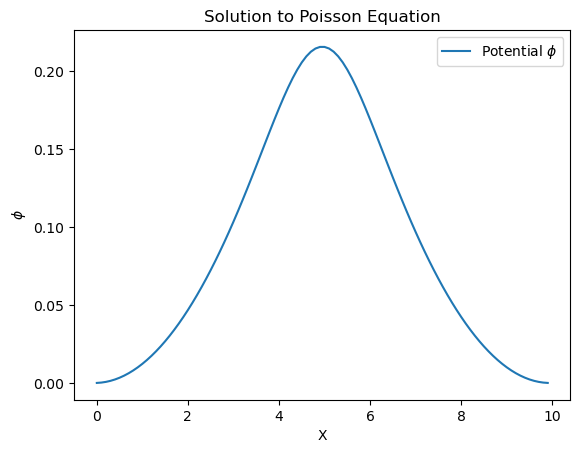

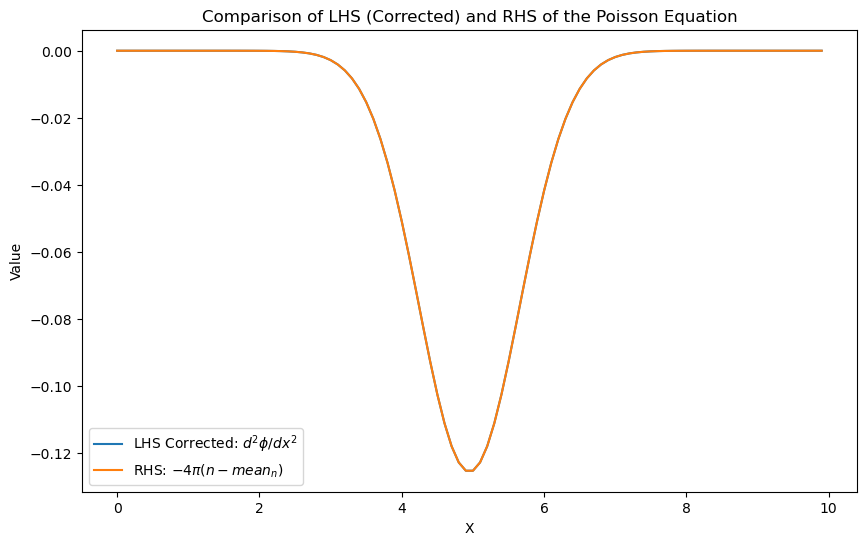

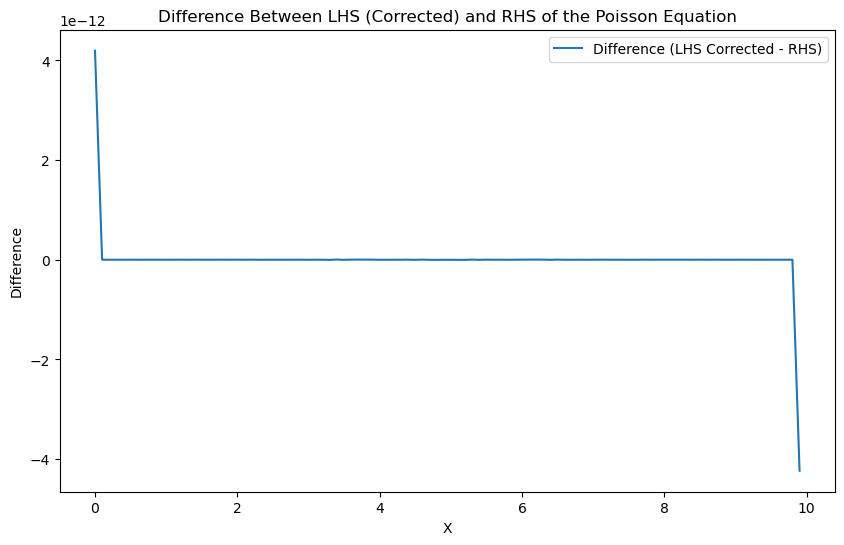

Test Case 1: Mean Difference = 1.806543e-18, Std Difference = 5.960287e-13, Max Difference = 4.234216e-12


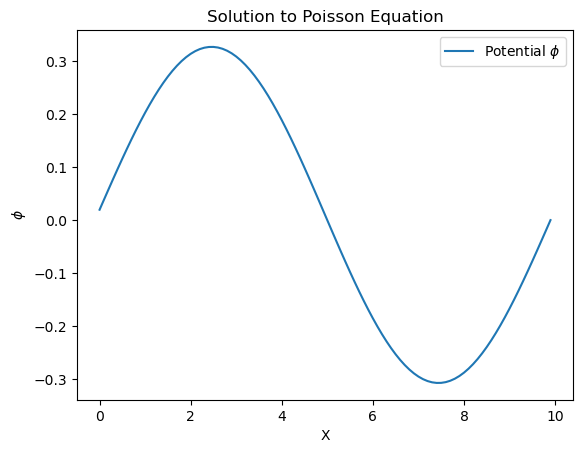

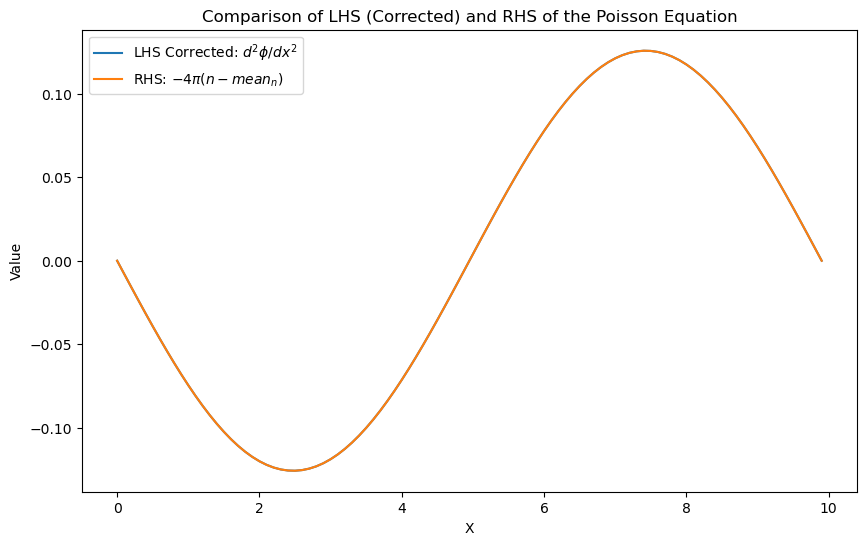

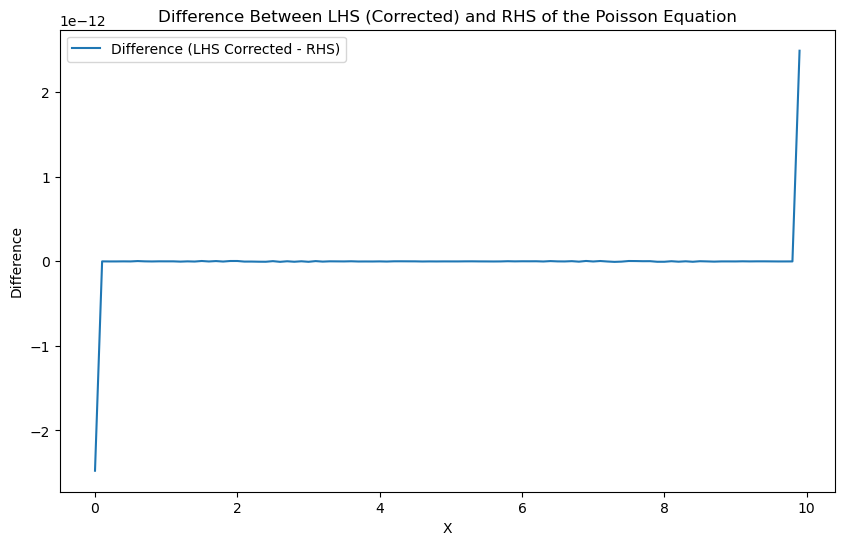

Test Case 2: Mean Difference = 2.081668e-18, Std Difference = 3.512438e-13, Max Difference = 2.491406e-12


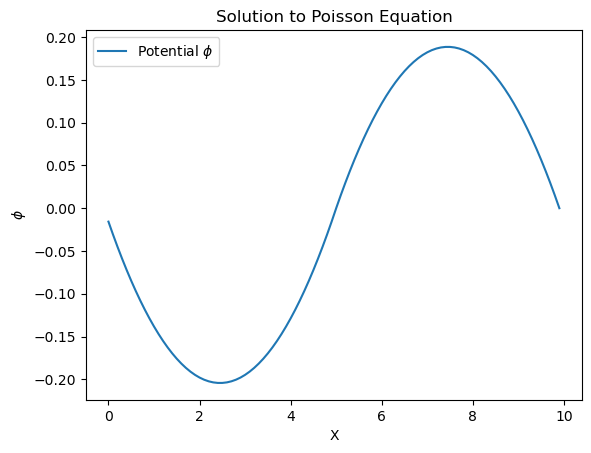

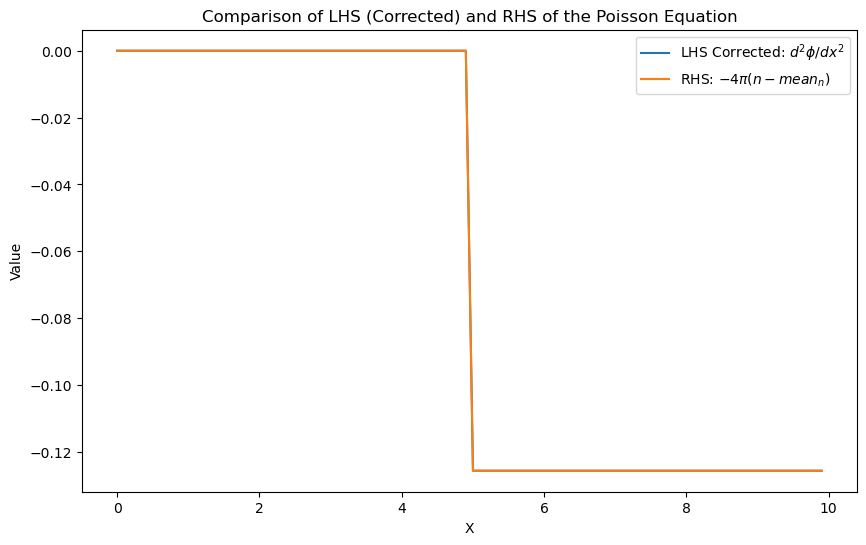

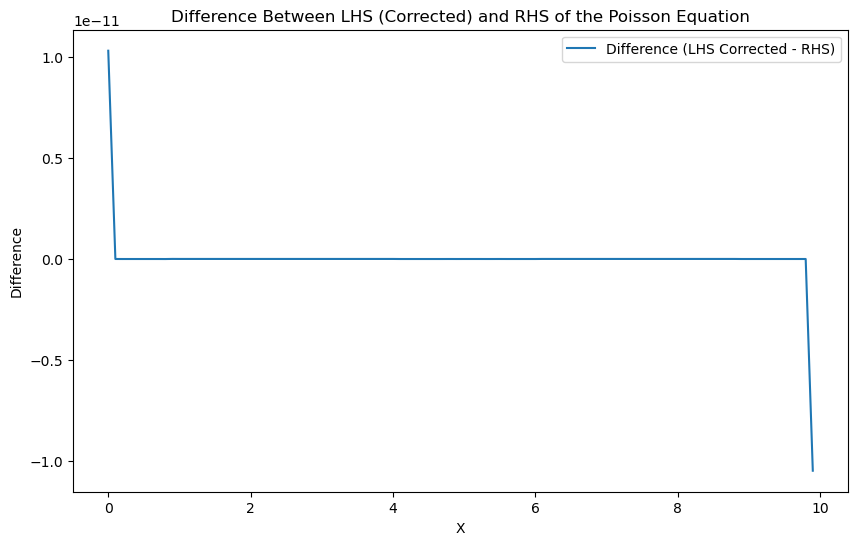

Test Case 3: Mean Difference = -1.693090e-17, Std Difference = 1.471190e-12, Max Difference = 1.048772e-11


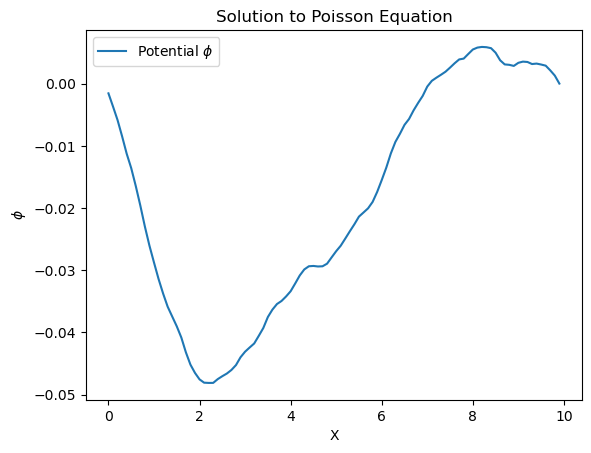

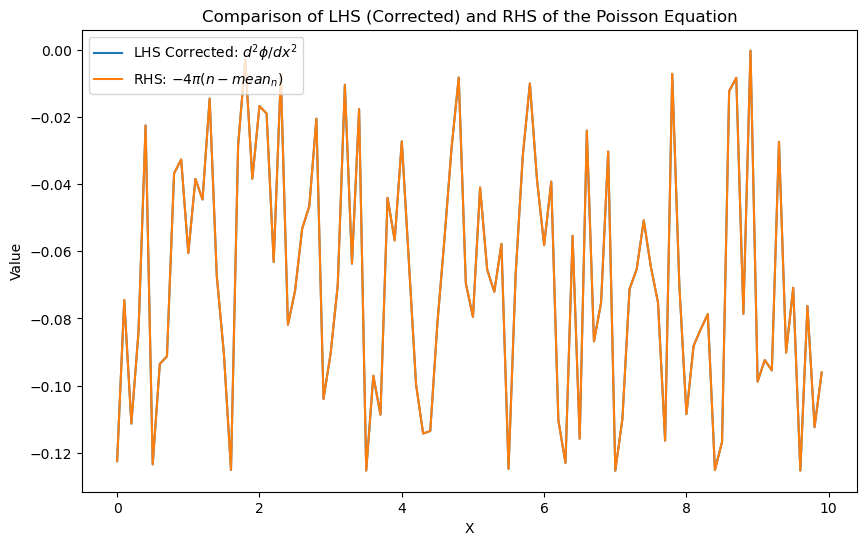

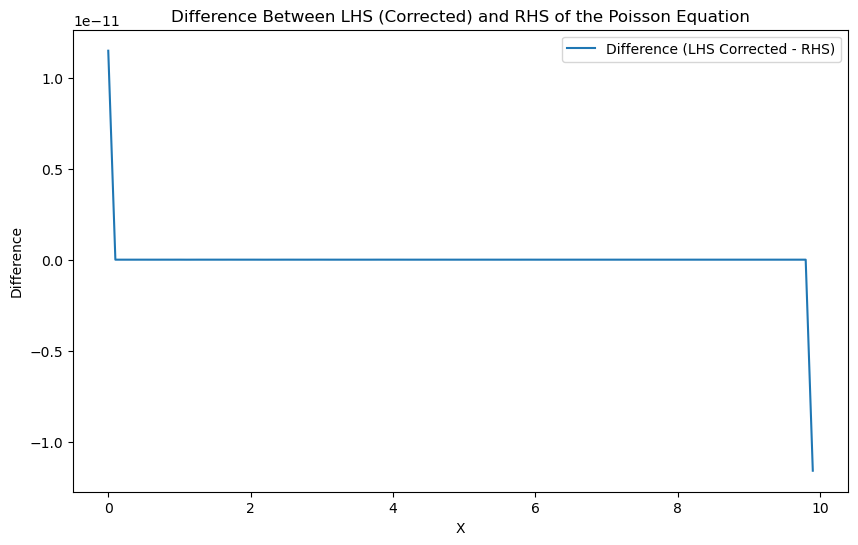

Test Case 4: Mean Difference = -3.079134e-19, Std Difference = 1.631208e-12, Max Difference = 1.159077e-11


[(1.8065426861635327e-18, 5.9602874227474e-13, 4.234216067057161e-12),
 (2.0816681711721684e-18, 3.512438271053205e-13, 2.491406386750938e-12),
 (-1.6930901125533637e-17, 1.4711902808642336e-12, 1.0487721802121541e-11),
 (-3.0791341698588324e-19, 1.6312077091407104e-12, 1.1590770010450058e-11)]

In [125]:
import numpy as np
import matplotlib.pyplot as plt

def solve_poisson(nx, n, dx):
    """
    Solves the Poisson equation with periodic boundary conditions using a special Thomas algorithm.
    """
    mean_n = np.mean(n)
    ρ = -4 * np.pi * (n - mean_n) * dx**2

    # Step 1: Compute potential at mesh point 0
    Φ = np.zeros(nx)
    Φ[0] = np.sum((np.arange(1, nx + 1) * ρ)) / nx

    # Step 2: Compute potential at mesh point 1
    Φ[1] = ρ[0] + 2 * Φ[0]

    # Step 3: Compute remaining potentials
    for i in range(2, nx):
        Φ[i] = ρ[i - 1] + 2 * Φ[i - 1] - Φ[i - 2]

    return Φ

def run_test_case(nx, L, n_func):
    dx = L / nx
    X = np.linspace(0, L, nx, endpoint=False)
    mean_n = 3 / (4 * np.pi)
    n = n_func(X, mean_n)

    # Solve for Φ
    Φ = solve_poisson(nx, n, dx)

    # Verify the solution by plugging it back into the Poisson equation
    lhs = (np.roll(Φ, -1) - 2 * Φ + np.roll(Φ, 1)) / (dx * dx)
    rhs = -4 * np.pi * (n - mean_n)

    # Calculate the vertical translation (offset) between lhs and rhs
    offset = lhs - rhs
    mean_offset = np.mean(offset)

    # Correct the lhs by subtracting the mean offset
    lhs_corrected = lhs - mean_offset

    # Calculate the difference between lhs_corrected and rhs
    difference = lhs_corrected - rhs
    mean_difference = np.mean(difference)
    std_difference = np.std(difference)
    max_difference = np.max(np.abs(difference))

    # Plot the results
    plt.figure()
    plt.plot(X, Φ, label="Potential $\phi$")
    plt.title("Solution to Poisson Equation")
    plt.xlabel("X")
    plt.ylabel("$\phi$")
    plt.legend()
    plt.show()

    # Plot to compare the LHS and RHS
    plt.figure(figsize=(10, 6))
    plt.plot(X, lhs_corrected, label="LHS Corrected: $d^2 \phi / dx^2$")
    plt.plot(X, rhs, label="RHS: $-4 \pi (n - mean_n)$")
    plt.title("Comparison of LHS (Corrected) and RHS of the Poisson Equation")
    plt.xlabel("X")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    # Plot the difference
    plt.figure(figsize=(10, 6))
    plt.plot(X, difference, label="Difference (LHS Corrected - RHS)")
    plt.title("Difference Between LHS (Corrected) and RHS of the Poisson Equation")
    plt.xlabel("X")
    plt.ylabel("Difference")
    plt.legend()
    plt.show()

    return mean_difference, std_difference, max_difference

# Test cases
def n_func_gaussian(X, mean_n):
    return mean_n + 0.01 * np.exp(-(X - np.mean(X))**2)

def n_func_sine(X, mean_n):
    return mean_n + 0.01 * np.sin(2 * np.pi * X / X.max())

def n_func_step(X, mean_n):
    return mean_n + 0.01 * (X > X.mean()).astype(float)

def n_func_random(X, mean_n):
    return mean_n + 0.01 * np.random.rand(len(X))

test_cases = [n_func_gaussian, n_func_sine, n_func_step, n_func_random]
nx = 100
L = 10

results = []
for i, n_func in enumerate(test_cases):
    mean_diff, std_diff, max_diff = run_test_case(nx, L, n_func)
    results.append((mean_diff, std_diff, max_diff))
    print(f"Test Case {i+1}: Mean Difference = {mean_diff:.6e}, Std Difference = {std_diff:.6e}, Max Difference = {max_diff:.6e}")

results

# Change to Solve IVP

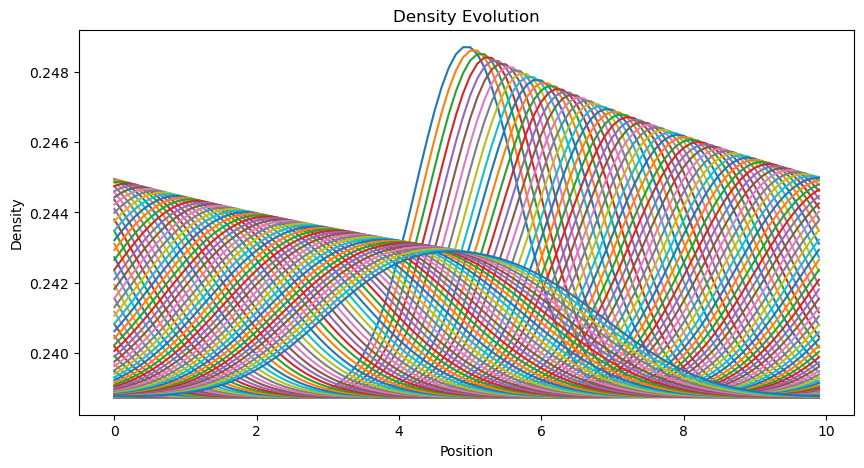

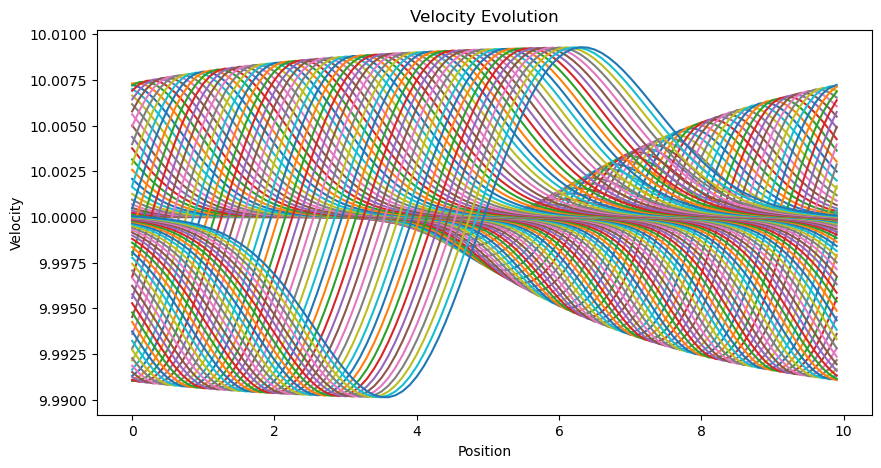

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Spatial domain setup
nx = int(1e2)
L = 10
dx = L / nx
X = np.linspace(0, L, nx, endpoint=False)

# Temporal domain setup
end_time = 1.0
num_snaps = 100

# Physics parameters
mean_n = 3 / (4 * np.pi)

# Initial conditions
initial_n = mean_n + 0.01 * np.exp(-(X - np.mean(X)) ** 2)  # Gaussian
initial_u = 10 * np.ones_like(X)
initial_T = np.ones_like(X)
initial_Φ = np.zeros_like(X)

# Combine initial conditions into a single array
initial_conditions = np.concatenate([initial_n, initial_u, initial_T, initial_Φ])

def system_of_equations(t, y):
    # Extract fields from the flattened array
    n = y[:nx]
    u = y[nx:2*nx]
    T = y[2*nx:3*nx]
    Φ = y[3*nx:4*nx]

    # Calculate derivatives
    dn_dt = -ddx(n * u, dx)
    du_dt = -u * ddx(u, dx) - T * ddx(n, dx) / n
    dT_dt = np.zeros_like(n)  # Placeholder for temperature evolution
    dΦ_dt = np.zeros_like(n)  # Placeholder for potential evolution

    # Return flattened derivative array
    return np.concatenate([dn_dt, du_dt, dT_dt, dΦ_dt])

# Use a stiff solver with a smaller maximum step size
solution = solve_ivp(
    system_of_equations, 
    [0, end_time], 
    initial_conditions, 
    t_eval=np.linspace(0, end_time, num_snaps+1),
    method='Radau',  # This is more suitable for stiff systems
    max_step=.5e-1     # Control the maximum step size to ensure stability
)

# Extract fields from solution
n_solutions = solution.y[:nx, :]
u_solutions = solution.y[nx:2*nx, :]
T_solutions = solution.y[2*nx:3*nx, :]
Φ_solutions = solution.y[3*nx:4*nx, :]

# Plotting - example for Density
plt.figure(figsize=(10, 5))
for i in range(n_solutions.shape[1]):
    plt.plot(X, n_solutions[:, i], label=f'Time = {solution.t[i]:.2f}s')
plt.title('Density Evolution')
plt.xlabel('Position')
plt.ylabel('Density')
# plt.legend()
plt.show()

# Plotting - example for Density
plt.figure(figsize=(10, 5))
for i in range(u_solutions.shape[1]):
    plt.plot(X, u_solutions[:, i], label=f'Time = {solution.t[i]:.2f}s')
plt.title('Velocity Evolution')
plt.xlabel('Position')
plt.ylabel('Velocity')
# plt.legend()
plt.show()

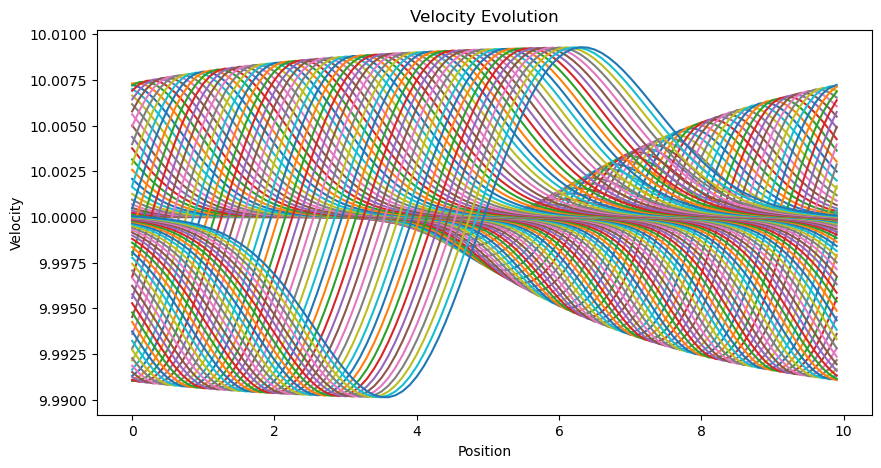

In [100]:
# Plotting - example for Density
plt.figure(figsize=(10, 5))
for i in range(u_solutions.shape[1]):
    plt.plot(X, u_solutions[:, i], label=f'Time = {solution.t[i]:.2f}s')
plt.title('Velocity Evolution')
plt.xlabel('Position')
plt.ylabel('Velocity')
# plt.legend()
plt.show()

/var/folders/mj/vl8lzxz54kq5ykc7s_pzj2980000gn/T/ipykernel_47093/1159282412.py:16: RuntimeWarning: overflow encountered in divide
  return (r(array) - l(array)) / (2 * dx)
/var/folders/mj/vl8lzxz54kq5ykc7s_pzj2980000gn/T/ipykernel_47093/1159282412.py:88: RuntimeWarning: invalid value encountered in divide
  u -= dt * u * ddx(u, dx) - T * ddx(n, dx) / n


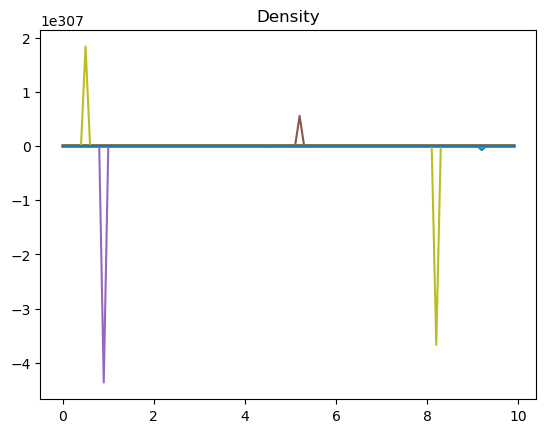

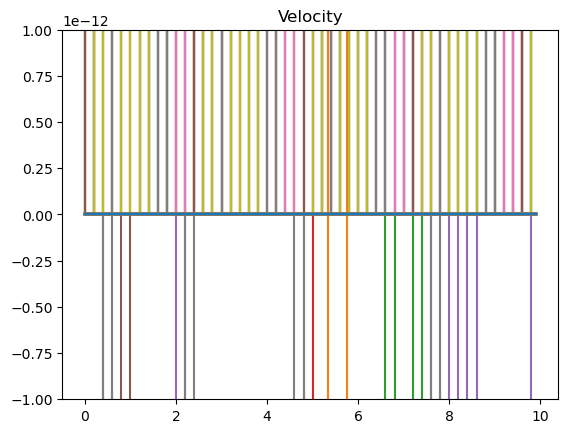

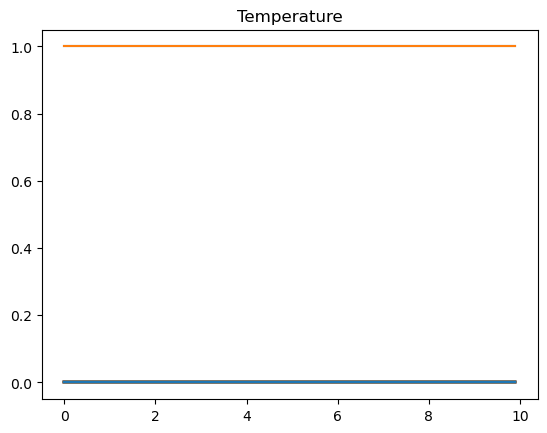

IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 640x480 with 1 Axes>